# Mean_Reversion_Analysis
**Author**: Hansen Han  
**Date**: February 4th, 2023  
  

#### Load Data

In [40]:
# Load 1 min BTC data from 2013 to 2019
import pandas as pd

df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)

# removed 2013 data
#df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)
#frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]

frames = [df2014, df2015, df2016, df2017, df2018, df2019]

crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

#Convert into roughly hourly data (note: some data is missing!, not ideal)
crypto_df = crypto_df[::60]
crypto_df.head()


,timestamp,open,close,high,low,volume
0,2014-01-01 00:02:00,730.24,730.2400,730.24,730.2400,0.010534
60,2014-01-01 01:32:00,739.00,737.6801,739.00,737.6801,10.828178
120,2014-01-01 02:51:00,748.88,748.8800,748.88,748.8800,2.205281
180,2014-01-01 04:33:00,747.20,748.9900,749.00,747.2000,9.000000
240,2014-01-01 06:24:00,744.00,744.0000,744.00,744.0000,3.000000


In [41]:
# View the data to make sure it looks right 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')
#plt.style.use('dark_background')

#sns.set_context("talk")
plt.figure(figsize=(20,6))
ax = sns.lineplot(x="timestamp", y="open", 
            data=crypto_df, ci=None)
ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
plt.xticks(rotation="vertical")

plt.show() # looks right...

KeyboardInterrupt: 

#### Simple Moving Average (SMA) Crossover Strategy Backtesting

In [ ]:
import numpy as np

def mean_reversion_backtester(sampled_data, 
                            order_sizing, 
                            ma_length, 
                            starting_capital,
                            buy_threshold,
                            take_profit,
                            stop_loss,
                            display_results):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma_length: moving average length (in hours)
        starting_capital: how much capital to start with (USD)
        buy_threshold: at what % below the moving average to buy (if 5%, should be 0.05)
        take_profit: at what % gain to sell and take the profit (if 5%, should be 0.05)
        stop_loss: at what % to sell and stop losses (if 5%, should be 0.05)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma = sampled_data.price.rolling(ma_length).mean()

    #truncate the data so they all are aligned 
    ma = list(ma[ma_length:])
    sampled_data = sampled_data[ma_length:]
    last_average_higher = "None"
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if x == 0:
            moves.append("Pass")

        else:
            #begin the trading mechanism

            # find the last move
            last_move = moves[len(moves)-1]

            #if the price dips below a set % from the moving average - BUY
            if last_move != "Buy" and current_price <= ma[x]*(1-buy_threshold):
                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

            #if the take profit or stop loss threshold is crossed - SELL
            elif last_move == "Buy" and (current_price >= ma[x]*(1+take_profit) or current_price <=ma[x]*(1-stop_loss)):
                fiat = fiat + position_size*current_price
                position_size = 0
                moves.append("Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                # reset the purchase price
                purchase_price = 0

            else:
                moves.append("Pass")
        
        #record the portfolio information
        portfolio_balance.append(position_size*current_price + fiat)
        baseline_balance.append(baseline_position_size*current_price)
        
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))

    # plot the final data
    plot_data = pd.DataFrame()
    plot_data['time'] = sampled_data['timestamp']
    plot_data['Baseline'] = baseline_balance
    plot_data['Mean Reversion'] = portfolio_balance

    if display_results == True:
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results

def plot_quarterly_data(backtest_results):
    '''
    Visualize quarterly data from a backtest run.

    Parameters:
        backtest_results: dict generated by sma_crossover_backtester()
    Returns:
        None
    '''

    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    quarterly_data = pd.DataFrame()
    quarterly_data['quarter'] = [x + 1 for x in range(0, len(backtest_results["quarter_return_rates"]))]
    quarterly_data['return'] = [x*100 for x in backtest_results["quarter_return_rates"]]
    quarterly_data['trades'] = backtest_results["quarter_trades"]
    quarterly_data['hit_rate'] = backtest_results["quarter_hit_rates"]
    quarterly_data['baseline'] = [x*100 for x in backtest_results["baseline_return_rates"]]

    # Hit Rate
    # if there are NAs in the hit rate, ignore it.
    if 'N/A' not in backtest_results['quarter_hit_rates']:
        clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
        graph = sns.barplot(x="quarter",y="hit_rate",data=quarterly_data,palette=clrs)
        #Drawing a horizontal line at 0.5
        graph.axhline(0.5)
        plt.show()

    # Returns
    clrs = ['green' if (x > 0) else 'red' for x in quarterly_data['return']]
    graph = sns.barplot(x="quarter",y="return",data=quarterly_data,palette=clrs)
    plt.show()

    # Number of trades
    graph = sns.barplot(x="quarter",y="trades",data=quarterly_data,palette=clrs)
    plt.show()

    # Comparing quarterly returns
    comparison_df = pd.DataFrame()
    comparison_df['Return (%)']  = list(quarterly_data['return']) + list(quarterly_data['baseline'])
    comparison_df['Quarter'] = [x for x in quarterly_data['quarter']] + [x for x in quarterly_data['quarter']]
    comparison_df['Strategy'] = ["Mean Reversion" for x in quarterly_data['quarter']] + ["Buy and Hold" for x in quarterly_data['quarter']]

    sns.barplot(data=comparison_df, x='Quarter', y='Return (%)', hue='Strategy')
    plt.show()

In [1]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

backtest_results = mean_reversion_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma_length = 48,
            buy_threshold = 0.05,
            take_profit=0.1,
            stop_loss=0.1, 
            starting_capital = 10000,
            display_results=True
        )

# Interpret backtest results
import statistics
print("Sharpe Ratio:", round(backtest_results['sharpe_ratio'],2))
print("Hit Rate:", backtest_results['hit_rate'])
print("SMA Crossover Return Rate:", round(backtest_results['final_return_rate']*100,2), "%")
print("Buy & Hold Return Rate:", round(backtest_results['baseline_return_rate']*100,2), "%")
print("Median Return per Quarter:", round(statistics.median(backtest_results['quarter_return_rates']*100), 2), "%")

plot_quarterly_data(backtest_results)

NameError: name 'crypto_df' is not defined

### What are the optimal parameters for a mean reversion strategy? 

In [30]:
from tqdm import trange # for tracking progress
import random

# test lots of combinations
ma_combinations = []
buy_thresholds = []
stop_loss_thresholds = []
take_profit_thresholds = []
median_return_rate_results = []
stdev_return_rate_results = []
profitable_quarters_results = [] 
cumulative_return_results = []
cumulative_baseline_return_results = []
sharpe_ratios = []

# run 100 different combinations (this can take up to a few hours, depending on the number of combinations being tested)
for x in trange(100):
    stop_loss = round(random.randrange(0, 100),2)/100
    buy_threshold = round(random.randrange(0, 100),2)/100
    take_profit = round(random.randrange(0, 100),2)/100
    ma_length = random.randrange(0, round(2191/2))

    ma_combinations.append(ma_length)
    buy_thresholds.append(buy_threshold)
    stop_loss_thresholds.append(stop_loss)
    take_profit_thresholds.append(take_profit)

    backtest_results = mean_reversion_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma_length = ma_length,
            buy_threshold = buy_threshold,
            take_profit = take_profit, 
            stop_loss = stop_loss,
            starting_capital = 10000,
            display_results = False
        )
    
    median_return_rate = statistics.median(backtest_results['quarter_return_rates'])
    stdev_return_rate = statistics.stdev(backtest_results['quarter_return_rates'])
    profitable_quarters = len([x for x in backtest_results['quarter_return_rates'] if x > 0])
    cumulative_return = backtest_results['final_return_rate']
    cumulative_baseline_return = backtest_results["baseline_return_rate"]
    sharpe_ratio = backtest_results["sharpe_ratio"]

    median_return_rate_results.append(median_return_rate)
    stdev_return_rate_results.append(stdev_return_rate)
    profitable_quarters_results.append(profitable_quarters)
    cumulative_return_results.append(cumulative_return)
    cumulative_baseline_return_results.append(cumulative_baseline_return)
    sharpe_ratios.append(sharpe_ratio)

# compile results into a table for exploration
optimization_results = pd.DataFrame()
optimization_results["ma"] = ma_combinations
optimization_results["buy_threshold"] = buy_thresholds
optimization_results["take_profit_threshold"] = take_profit_thresholds
optimization_results["stop_loss_threshold"] = stop_loss_thresholds
optimization_results["median_return_rate"] = median_return_rate_results
optimization_results["stdev_return_rate"] = stdev_return_rate_results
optimization_results["cumulative_return"] = cumulative_return_results
optimization_results["cumulative_baseline_return"] = cumulative_baseline_return_results
optimization_results["profitable_quarters"] = profitable_quarters_results
optimization_results["sharpe_ratio"] = sharpe_ratios

optimization_results.head()

100%|██████████| 100/100 [3:58:03<00:00, 142.84s/it]  


,ma,buy_threshold,take_profit_threshold,stop_loss_threshold,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters,sharpe_ratio
0,50,0.71,0.98,0.21,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
1,441,0.12,0.47,0.36,-0.066559,1.082372,-0.126943,76.404826,8,0.072279
2,145,0.58,0.27,0.68,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
3,862,0.25,0.14,0.77,-0.008372,2.321237,86.469704,76.404826,9,0.082208
4,882,0.11,0.32,0.63,-0.008372,2.221163,82.348730,76.404826,9,0.081784


In [31]:
# save optimization results to csv (since it takes so long!)
optimization_results.to_csv("mean_reversion_optimization_results_100_runs.csv")

In [32]:
# 77 out of 100 random runs was profitable
optimization_results[optimization_results.cumulative_return > 0]

,ma,buy_threshold,take_profit_threshold,stop_loss_threshold,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters,sharpe_ratio
0,50,0.71,0.98,0.21,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
2,145,0.58,0.27,0.68,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
3,862,0.25,0.14,0.77,-0.008372,2.321237,86.469704,76.404826,9,0.082208
4,882,0.11,0.32,0.63,-0.008372,2.221163,82.348730,76.404826,9,0.081784
5,786,0.48,0.69,0.95,0.000000,0.412511,0.155990,76.404826,3,0.025725
...,...,...,...,...,...,...,...,...,...,...
92,494,0.83,0.47,0.57,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
94,18,0.71,0.42,0.84,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
96,571,0.69,0.42,0.96,-0.008372,196.983472,7217.000000,76.404826,9,0.042318
98,166,0.42,0.06,0.97,-0.008372,196.983472,7217.000000,76.404826,9,0.042318


In [33]:
# what are the parameters for the run with the highest cumulative returns?
optimization_results[optimization_results.cumulative_return == max(optimization_results['cumulative_return'])]


,ma,buy_threshold,take_profit_threshold,stop_loss_threshold,median_return_rate,stdev_return_rate,cumulative_return,cumulative_baseline_return,profitable_quarters,sharpe_ratio
40,23,0.27,0.29,0.18,0.024907,106.413292,8609.721401,76.404826,10,0.043464


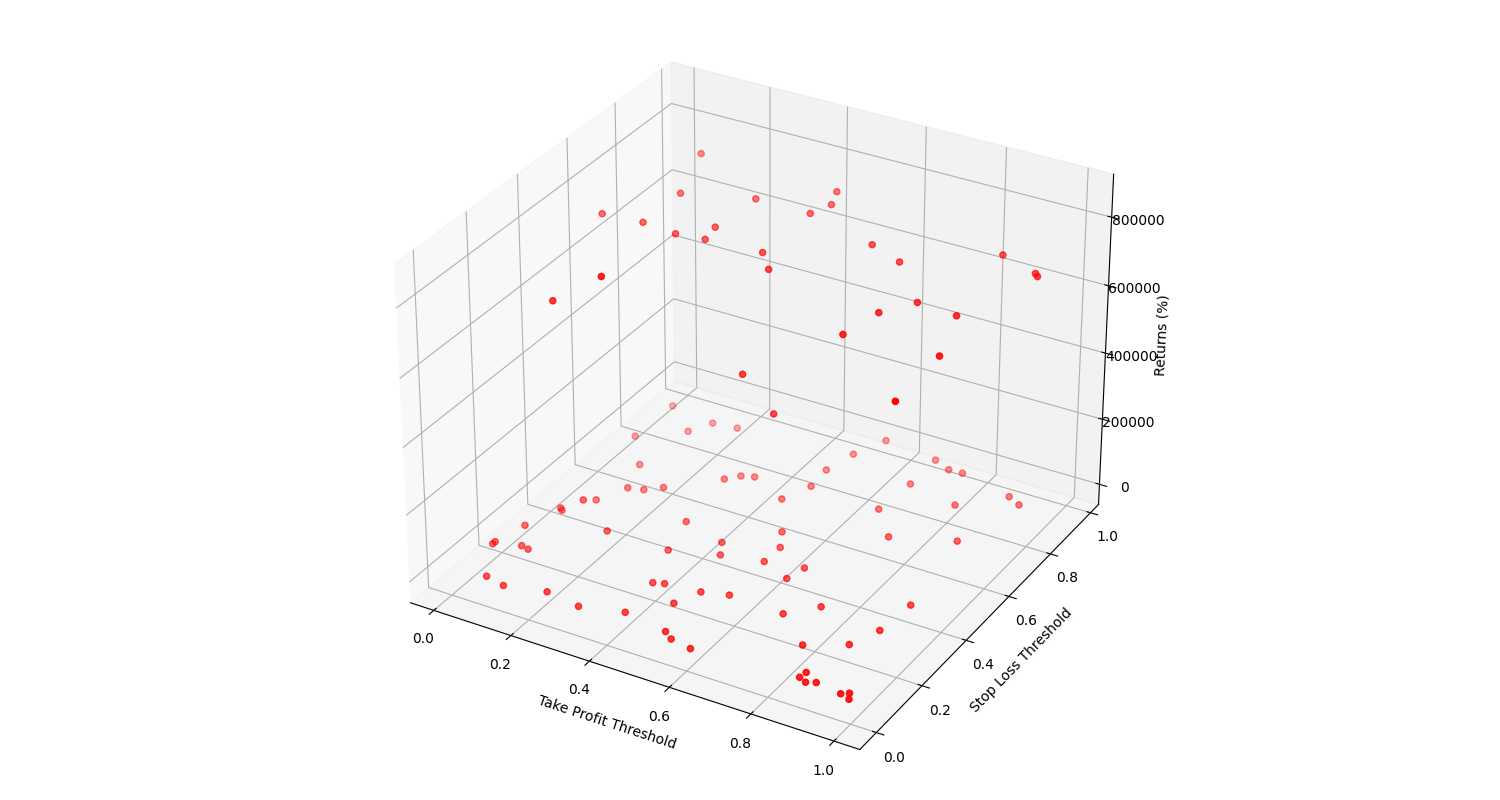

In [34]:
# Create a 3D interactive plot to find relationships between moving average lengths and cumulative return rates
%matplotlib widget
  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.style.use('classic')

# Plot the data for the top 25% of cumulative returns
#xs = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma1_length']
#ys = optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['ma_length']
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['cumulative_return']]

# Plot the data for all returns
xs = optimization_results['take_profit_threshold']
ys = optimization_results['stop_loss_threshold']
zs = [x*100 for x in optimization_results['cumulative_return']]

# Also try using this instead of cumulative return to look at median return 
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['median_return_rate']]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
optimization_plot = ax.scatter(xs, ys, zs, color='red')
  
# setting title and labels
ax.set_title("Moving Average Length and Cumulative Returns")
ax.set_xlabel('Take Profit Threshold')
ax.set_ylabel('Stop Loss Threshold')
ax.set_zlabel('Returns (%)')
  
# displaying the plot
plt.show()

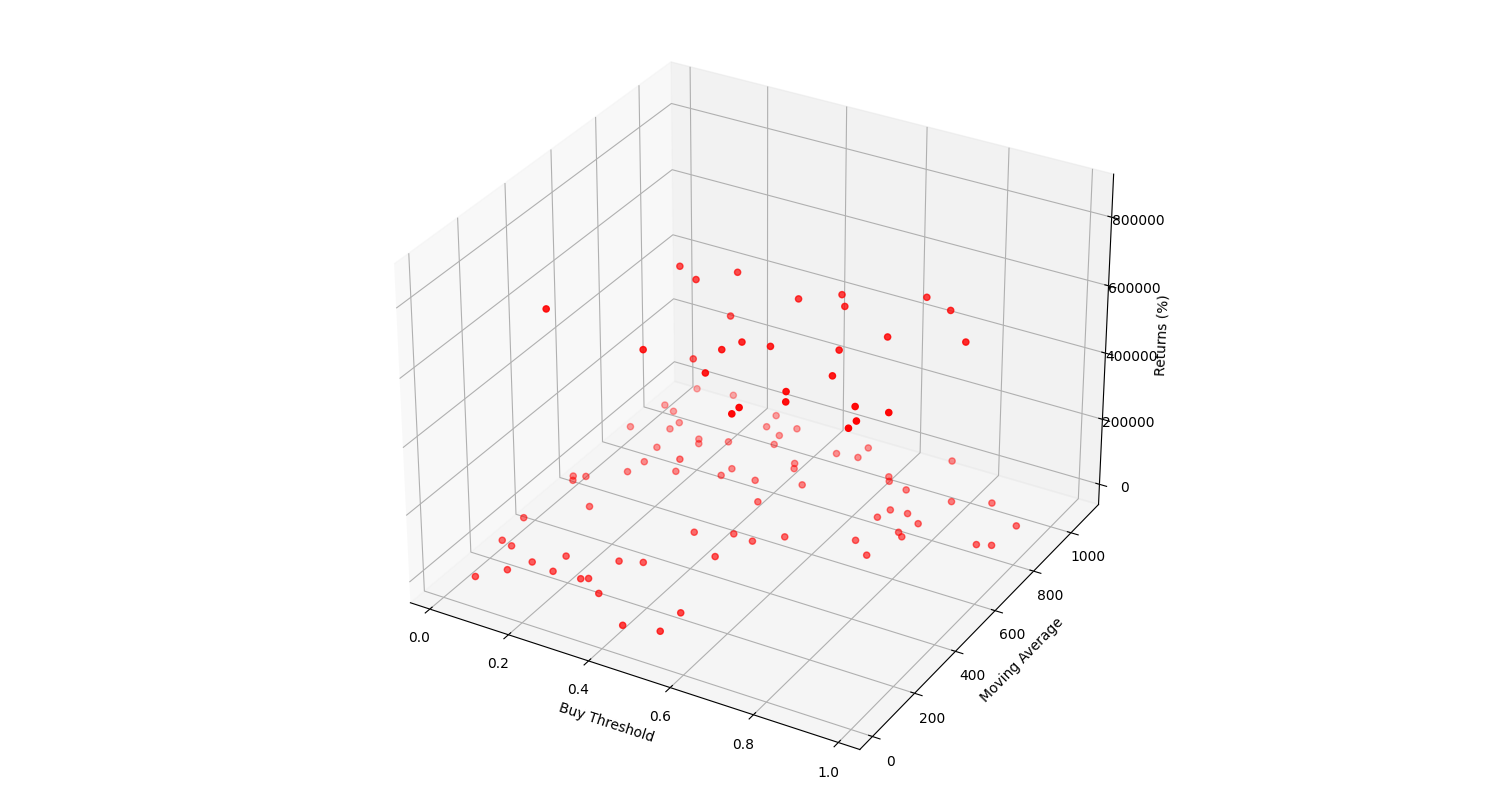

In [37]:
# Plot the data for all returns
xs = optimization_results['buy_threshold']
ys = optimization_results['ma']
zs = [x*100 for x in optimization_results['cumulative_return']]

# Also try using this instead of cumulative return to look at median return 
#zs = [x*100 for x in optimization_results[optimization_results.cumulative_return >= optimization_results.describe()['cumulative_return']['75%']]['median_return_rate']]
  
# creating figure
fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
optimization_plot = ax.scatter(xs, ys, zs, color='red')
  
# setting title and labels
ax.set_title("Moving Average Length and Cumulative Returns")
ax.set_xlabel('Buy Threshold')
ax.set_ylabel('Moving Average')
ax.set_zlabel('Returns (%)')
  
# displaying the plot
plt.show()